In [1]:
using ITensors
import TensorCrossInterpolation as TCI

using TCIITensorConversion

using Plots
using Printf

using Random
using FFTW
using Statistics


In [2]:
"""v starts from 1"""
function bin2dec(v::Vector{Int})
    L=length(v)
    return (2 .^(L-1:-1:0)' * (v.-1))[1]
end
    

bin2dec

In [3]:
function dec2bin(x::Int, L::Int)
    return [parse(Int, i)+1 for i in string(x, base=2, pad=L)]
    
end

dec2bin (generic function with 1 method)

In [4]:
localdims = fill(2, 10)

10-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [5]:
# f(v) = 1/(1 + v' * v)
# f(v) = 1/(1. + bin2dec(v))
k=15
f(v)=abs.(cos.(bin2dec(v) * k* 2*pi/2^length(v)))

epsilon=0.5
f_eps(v)=sqrt.(cos.(bin2dec(v) * k* 2*pi/2^length(v)).^2 .+epsilon^2)


# random



f_eps (generic function with 1 method)

In [6]:
L=10

10

In [15]:
rng = MersenneTwister(1)
random_array = rand(rng, 2^L)
random_array_red=abs.(ifft(truncate_FT(fft(random_array),0.45)))
f_rand(v)=random_array[bin2dec(v)+1]
f_rand_red(v)=random_array_red[bin2dec(v)+1]

f_rand_red (generic function with 1 method)

In [11]:
function truncate_FT(a,prop)
    len=length(a)
    idx=floor(Int,len*prop)
    b=copy(a)
    b[div(len,2)-idx:div(len,2)+idx].=0
    return b
end

truncate_FT (generic function with 1 method)

In [12]:
function generate_f_rand(seed::Int,L::Int,prop)
    rng = MersenneTwister(seed)
    random_array = rand(rng, 2^L)
    random_array_red=abs.(ifft(truncate_FT(fft(random_array),prop)))
    f_rand_red(v)=random_array_red[bin2dec(v)+1]
    return f_rand_red
end

generate_f_rand (generic function with 1 method)

In [48]:
function generate_f_rand_eps(seed::Int,L::Int,eps)
    rng = MersenneTwister(seed)
    random_array = rand(rng, 2^L)
    # random_array_red=abs.(ifft(truncate_FT(fft(random_array),prop)))
    f_rand_eps(v)=sqrt(random_array[bin2dec(v)+1]^2+eps^2)
    return f_rand_eps
end

generate_f_rand_eps (generic function with 1 method)

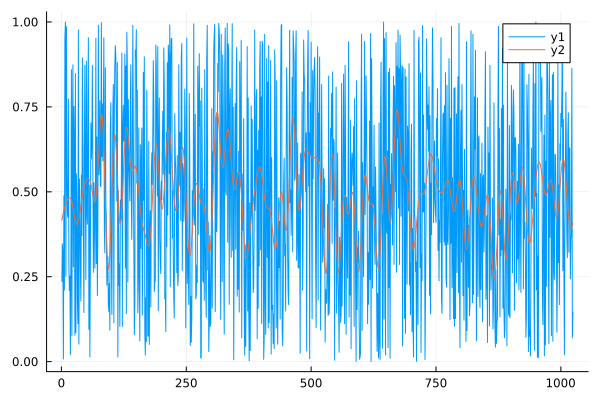

In [16]:
plot(random_array)
plot!(random_array_red)

In [53]:
function fit_tensor(L::Int, func::Function;tol = 1e-8)
    localdims = fill(2, L)
    f(v)=abs.(cos.(bin2dec(v) * k* 2*pi/2^length(v)))
    tci, ranks, errors = TCI.crossinterpolate2(Float64, func, localdims; tolerance=tolerance)
    return tci, ranks, errors
end

fit_tensor (generic function with 1 method)

In [54]:
function fit_tensor_eps(L::Int,seed::Int,prop;tol = 1e-8)
    localdims = fill(2, L)
    func=generate_f_rand_eps(seed,L,prop)
    func_cache = TCI.CachedFunction{Float64}(func,localdims)
    tci, ranks, errors = TCI.crossinterpolate2(Float64, func_cache, localdims; tolerance=tol)
    return tci, ranks, errors
end

fit_tensor_eps (generic function with 1 method)

In [ ]:
function fit_tensor_rand(L::Int,seed::Int,prop;tol = 1e-8)
    localdims = fill(2, L)
    func=generate_f_rand(seed,L,prop)
    func_cache = TCI.CachedFunction{Float64}(func,localdims)
    tci, ranks, errors = TCI.crossinterpolate2(Float64, func_cache, localdims; tolerance=tol)
    return tci, ranks, errors
end

fit_tensor_rand (generic function with 1 method)

In [37]:
tci, ranks, errors=fit_tensor(10,f_rand)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 32, [10, 32, 32, 32], [0.0, 0.0, 0.0, 0.0])

In [18]:
tci, ranks, errors=fit_tensor_rand(20,1,0.1)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 1024, [10, 59, 261, 1024, 1024, 1024], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [64]:
tci, ranks, errors=fit_tensor_rand(20,1,1/2-1/2^11)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 64, [10, 54, 64, 64, 64], [7.396791506744921e-9, 9.323117829680286e-9, 9.758860752889996e-9, 9.758860752889996e-9, 9.758860752889996e-9])

In [86]:
tci, ranks, errors=fit_tensor_rand(20,1,1//2-1//2^19)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 5, [7, 5, 5, 5], [8.838417123825472e-9, 8.150460122689458e-9, 8.150460233651482e-9, 8.150460233651482e-9])

In [58]:
tci, ranks, errors=fit_tensor_eps(10,1,0.001)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 32, [10, 32, 32, 32], [0.0, 0.0, 0.0, 0.0])

In [19]:
ensemble_size=10
prop_list=1 .//2 .^(19:-1:1)
tol_list=[1e-8,1e-10,]
ranks_map = zeros(length(tol_list),length(prop_list),ensemble_size)
L=20
for (tol_idx,tol) in enumerate(tol_list)
    for (prop_idx,prop) in enumerate(prop_list)
        println(prop)
        for seed in 1:ensemble_size
            tci, ranks, errors=fit_tensor_rand(L,seed,1//2-prop;tol=tol)
            ranks_map[tol_idx,prop_idx,seed] = ranks[end]
        end
    end
end


1//524288
1//262144
1//131072
1//65536
1//32768
1//16384
1//8192
1//4096
1//2048
1//1024
1//512
1//256
1//128
1//64
1//32
1//16
1//8
1//4
1//2
1//524288
1//262144
1//131072
1//65536
1//32768
1//16384
1//8192
1//4096
1//2048
1//1024
1//512
1//256
1//128
1//64
1//32
1//16
1//8
1//4
1//2


In [20]:
mean_squeeze(arr, axis) = dropdims(mean(arr, dims=axis), dims=axis)

mean_squeeze (generic function with 1 method)

In [21]:
ranks_map[1,:,:]

19×10 Matrix{Float64}:
    5.0     5.0     5.0     5.0     5.0  …     5.0     5.0     5.0     5.0
    7.0     7.0     7.0     7.0     7.0        7.0     7.0     7.0     7.0
    8.0     8.0     8.0     8.0     8.0        8.0     8.0     8.0     8.0
   10.0    10.0    10.0    11.0    10.0       10.0    10.0    10.0    10.0
   15.0    15.0    15.0    14.0    14.0       14.0    15.0    14.0    16.0
   16.0    16.0    16.0    16.0    16.0  …    16.0    16.0    17.0    16.0
   23.0    23.0    22.0    24.0    24.0       22.0    25.0    26.0    21.0
   32.0    32.0    32.0    32.0    32.0       32.0    32.0    32.0    31.0
   44.0    50.0    48.0    48.0    52.0       45.0    51.0    40.0    51.0
   64.0    55.0    64.0    64.0    56.0       64.0    64.0    64.0    64.0
   64.0    91.0   100.0    96.0    77.0  …   102.0   102.0   101.0   101.0
  128.0   128.0   128.0   128.0   128.0      128.0   128.0   128.0   128.0
  192.0   161.0   198.0   218.0   206.0      222.0   194.0   231.0   197.0
  

In [22]:
ranks_map_ave=mean_squeeze(ranks_map,3)

2×19 Matrix{Float64}:
 5.0  7.0  8.0  10.1  14.6  16.1  23.4  …  626.5  1023.2  1024.0  1024.0
 6.5  8.0  9.6  12.4  16.0  19.4  30.9     943.1  1024.0  1024.0  1024.0

In [ ]:
ranks_map_ave

In [66]:
p=plot()
for (tol_idx,tol) in enumerate(tol_list)
    plot!(p,2*(prop_list),ranks_map_ave[tol_idx,:],xscale=:log10, yscale=:log10,label="tol=$tol",seriestype=:path, marker=:circle)
end
plot!(legend=:topleft)
plot!(xlabel="truncation of fourier component",ylabel="max bond dim",xlims=(1/2^18.9, 1.1),)
plot!(xticks=:auto, xminorgrid=true,yticks=:auto, yminorgrid=true)

display(p)


In [60]:
collect(0:0.01:0.1)

11-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1

In [61]:
ensemble_size=10
eps_list=0:0.01:0.1
tol_list=[1e-8,1e-10,]
ranks_map = zeros(length(tol_list),length(eps_list),ensemble_size)
L=10
for (tol_idx,tol) in enumerate(tol_list)
    for (eps_idx,eps) in enumerate(eps_list)
        println(eps)
        for seed in 1:ensemble_size
            tci, ranks, errors=fit_tensor_eps(L,seed,eps;tol=tol)
            ranks_map[tol_idx,eps_idx,seed] = ranks[end]
        end
    end
end


0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1


In [63]:
ranks_map_ave=mean_squeeze(ranks_map,3)

2×11 Matrix{Float64}:
 32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0
 32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0

In [65]:
p=plot()
for (tol_idx,tol) in enumerate(tol_list)
    plot!(p,2*(prop_list),ranks_map_ave[tol_idx,:],xscale=:log10, yscale=:log10,label="tol=$tol",seriestype=:path, marker=:circle)
end
plot!(legend=:topleft)
plot!(xlabel="truncation of fourier component",ylabel="max bond dim",xlims=(1/2^18.9, 1.1),)
plot!(xticks=:auto, xminorgrid=true,yticks=:auto, yminorgrid=true)

display(p)


In [38]:
TCI.linkdims(tci)

9-element Vector{Int64}:
  2
  4
  8
 16
 32
 16
  8
  4
  2

In [47]:
tci_red, ranks_red, errors_red=fit_tensor(10,f_rand_red)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 23, [8, 24, 23, 23, 23], [0.0, 8.475361230098635e-9, 6.536577574880786e-9, 6.536577574880786e-9, 6.536577574880786e-9])

In [48]:
TCI.linkdims(tci_red)

9-element Vector{Int64}:
  2
  4
  8
 16
 23
 15
  8
  4
  2

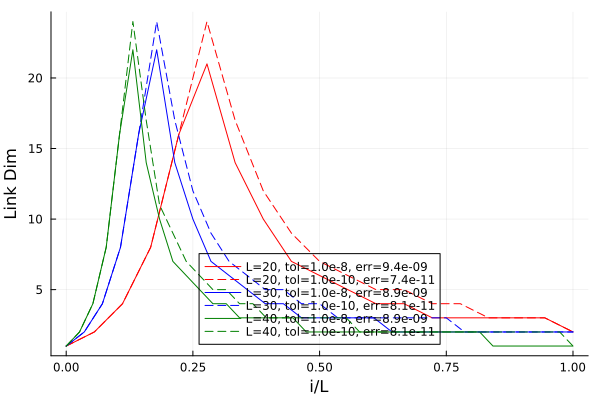

In [20]:
# L=20
tolerance_list = [1e-8,1e-10]
colors = [:red, :blue, :green]
p=plot(format=:png)
for (L,color) in zip([20,30,40],colors)
    for (tolerance,ls) in zip(tolerance_list,[:solid, :dash])
        tci, ranks, errors = fit_tensor(L;tolerance = tolerance)
        formatted_error = @sprintf("%.1e", errors[end])
        plot!(p,range(0,1,L-1),TCI.linkdims(tci),ylabel="Link Dim",xlabel="i/L",label="L=$L, tol=$tolerance, err=$formatted_error", color=color,linestyle=ls)
    end
end
plot!(p, legend=:bottom, legend_background_color=:transparent)
display(p)

In [ ]:
# tolerance = 1e-8
# tci, ranks, errors = TCI.crossinterpolate2(Float64, f, localdims; tolerance=tolerance)
L=20
tci, ranks, errors = fit_tensor(L;tolerance = 1e-12)

In [ ]:
plot(TCI.linkdims(tci),ylabel="Link Dim")

In [ ]:
# L=20
x=(0:2^L-1)
y=[f(dec2bin(i,L)) for i in x]

y_fit = [tci(dec2bin(i,L)) for i in x]
x=x/2^L

# plot_layout = @layout([a; b])

p=plot(x,y,label="Original")
plot!(p,x,y_fit,label="Interpolation")

# plot!(p,1:L,TCI.linkdims(tci),ylabel ="Link dim", subplot=2,)

# plot(p1,p2,layout = @layout([1 2]))

In [ ]:
x=(0:2^10-1)
epsilon=1e-1
k=15
y=[f_eps(dec2bin(i,10)) for i in x]

In [ ]:
abs.(fft(y))

In [ ]:
plot(abs.(fftshift(fft(y))))

In [ ]:
x=(0:2^10-1)
k=15
# epsilon=1e-1
epsilon_list=[1e-1,1e-3,1e-5]
p=plot()
for epsilon in epsilon_list
    y=[f_eps(dec2bin(i,10)) for i in x]
    plot!(abs.(fftshift(fft(y))),)
end

display(p)

In [ ]:
plot(x,y)

In [ ]:
TCI.rank(tci)

In [ ]:
MPS(tci)

In [ ]:
f([2,2,1,1,1,1,1,1,1,1])

In [ ]:
f([1,1,1,1,1,2,2,2,2,1])

In [ ]:
ranks

In [ ]:
MPS(TCI.TensorTrain(tci))

In [ ]:
MPS(tci)

In [ ]:
TCI.rank(tci)

In [ ]:
TCI.linkdims(tci)

In [ ]:
(tci)

In [ ]:
mps=MPS(tci)

In [ ]:
mps[1]

In [ ]:
tci

In [ ]:
sites = siteinds("Qubit",4)

In [ ]:
zz=randomMPS(sites)

In [ ]:
array(prod(zz))

In [ ]:
zz_tci=TCI.TensorTrain(zz)

In [ ]:
zz_tci([1,2,1,1])

In [ ]:
println(tci)

In [ ]:
tci([])

In [ ]:
errors

In [ ]:
f([1,1,2,1,1,1,1,1,1,1])

In [ ]:
tci([1,1,2,1,1,1,1,1,1,1])

In [ ]:
(tci)